In [1]:
%matplotlib inline
import random
import math
import cmath

import matplotlib.pyplot as plt
import IPython.display as disp

import potsim

plt.style.use('ggplot')
random.seed(0) # just for demo'ing

# POTS Modem Filter Demo

In [2]:
FS = 44100
BAUD = 50
BITS_PER_SYMBOL = 1
WORD_LEN = 8
WORDS_TO_TX = int((BAUD / WORD_LEN) * 3.9)
BITS_TO_TX = WORDS_TO_TX * WORD_LEN

Fcarrier = 1000

In [3]:
data = []
for n in range(WORDS_TO_TX):
    data.append(random.randrange(2**WORD_LEN))

bindata = [1, 0] # start with 1 and 0 to detect start of message
for byte in data:
    for i in range(8):
        bindata.append(1 if (byte & 2**i) else 0)

n_bits = len(bindata)
bindata[:20]

[1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0]

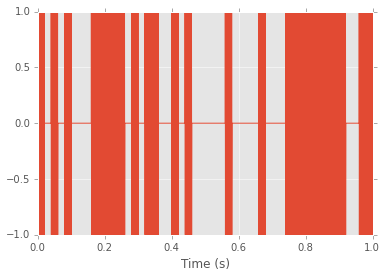

In [4]:
n_samples = int(n_bits * FS / (BAUD * BITS_PER_SYMBOL))
mod_scaler = FS / (BAUD * BITS_PER_SYMBOL)

signal = []
for i in range(n_samples):
    modulator = bindata[int(i // mod_scaler)]
    signal.append(modulator * math.sin(2 * math.pi * Fcarrier * i/FS))

t = [i/FS for i in range(n_samples)]
plt.plot(t, signal)
plt.xlim((0, 1))
plt.xlabel('Time (s)')
pass # suppress IPython output

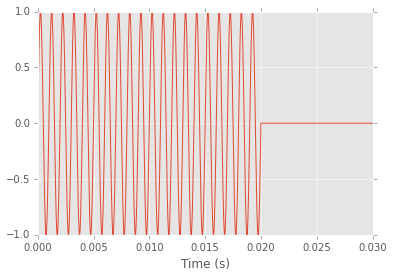

In [5]:
plt.plot(t, signal)
plt.xlim((0, 0.03))
plt.xlabel('Time (s)')
pass

In [6]:
print('Transmit file is {:.3f} seconds in length.'.format(len(signal) / FS))
disp.Audio(signal, rate=FS)

Transmit file is 3.880 seconds in length.


In [7]:
# import numpy as np
# received = potsim.pots(np.array(signal))
import requests
POTS_URL = 'http://alpine-cupcake-2461.herokuapp.com/pots/json'
msg = {'data': signal, 'seed': 0}
received = requests.post(POTS_URL, json=msg).json()['data']
disp.Audio(received, rate=FS)

Note that the signal has been delayed by a random amount (though for the demo it's held constant with the specified seed)

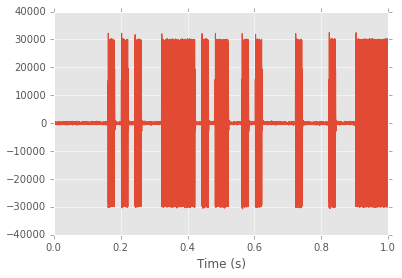

In [8]:
t_rec = [i/FS for i in range(len(received))]
plt.plot(t_rec, received)
plt.xlim(0, 1)
plt.xlabel('Time (s)')
pass

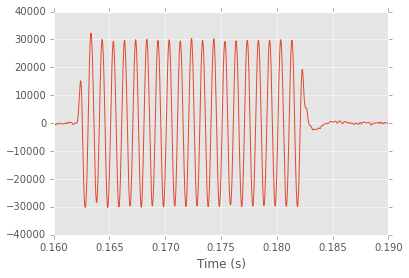

In [9]:
plt.plot(t_rec, received)
plt.xlim(0.16, 0.19)
plt.xlabel('Time (s)')
pass

In [10]:
# Goertzel filter https://en.wikipedia.org/wiki/Goertzel_algorithm
fnorm = Fcarrier / FS
s = [0, 0]
y_abs = [0]
y_diff = []
for xn in received:
    sn = xn + 2 * math.cos(2 * math.pi * fnorm) * s[-1] - s[-2]
    yn = sn - cmath.exp(-2 * math.pi * 1j * fnorm) * s[-1]
    s.append(sn)
    y_abs.append(abs(yn))
    y_diff.append(y_abs[-1] - y_abs[-2])

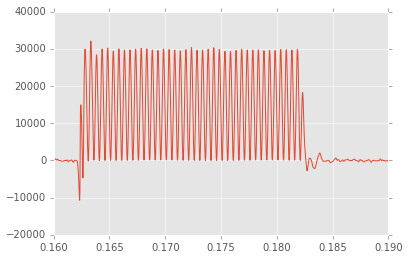

In [11]:
plt.plot(t_rec, y_diff)
plt.xlim(0.16, 0.19)
pass

In [12]:
# Convolve with the expected symbol to average out noise. The symbol is a 
# box, so we can just sum ranges of the filter output.
samples_per_symbol = FS / BAUD

spsi = int(samples_per_symbol)
estimator = []
for i in range(len(received) - spsi):
    estimator.append(sum(y_diff[i:i+spsi]))

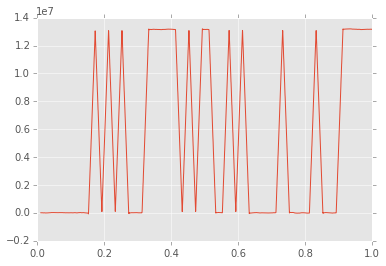

In [13]:
plt.plot(t_rec[spsi//2 : -spsi//2], estimator)
plt.xlim(0, 1)
pass

In [14]:
# Find start (the 1, 0)
emin, emax = min(estimator), max(estimator)
emid = (emax + emin) / 2
#start = np.argmax(estimator > 0.90 * emax)

# Find rising edge
i = 0
while True:
    if estimator[i] > emid:
        rise = i
        break
    i += 1
i += int(0.1 * FS / BAUD)
while True:
    if estimator[i] < emid:
        fall = i
        break
    i += 1
    
message_start = (rise + fall) / 2

In [15]:
check_at = message_start 

# skip the preamble (the 1, 0 at the beginning to detect message start)
check_at += 2 * samples_per_symbol

recovered_data = []
for i in range(BITS_TO_TX):
    recovered_data.append(1 if estimator[int(check_at)] > emid else 0)
    check_at += samples_per_symbol

## Check the data was recovered correctly

In [16]:
transmitted_net_data = bindata[2:] # again skip preamble
for tx_bit, rx_bit in zip(transmitted_net_data, recovered_data):
    assert tx_bit == rx_bit
else:
    print("Everything OK!")

Everything OK!


In [17]:
tx_time = len(signal) / FS
print("Transmitted {} bits of payload in {} seconds".format(BITS_TO_TX, tx_time))
print("Net data rate: {:.2f} bps".format(BITS_TO_TX/tx_time))

Transmitted 192 bits of payload in 3.88 seconds
Net data rate: 49.48 bps
